In [1]:
%pip install -q --upgrade qiskit>=1.2.0 qiskit-algorithms>=0.3.1 qiskit-machine-learning>=0.8.3 qiskit-aer scikit-learn>=1.3.0 pandas>=2.0.0 matplotlib
import sys 
print(f"✅ Installation complete!") 
print(f"🐍 Python version: {sys.version_info.major}.{sys.version_info.minor}") 

Note: you may need to restart the kernel to use updated packages.
✅ Installation complete!
🐍 Python version: 3.12



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# Verify installations 
try: 
    import qiskit 
    import qiskit_algorithms 
    import qiskit_machine_learning 
    print(f"✅ Qiskit version: {qiskit.version}") 
    print(f"✅ All packages installed successfully!") 
except ImportError as e: 
    print(f"❌ Import error: {e}") 
    print("🔄 Please restart runtime and try again")

✅ Qiskit version: <module 'qiskit.version' from 'c:\\Users\\Hridi\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\qiskit\\version.py'>
✅ All packages installed successfully!


In [2]:
# ========================================
# CELL 2: CORRECTED IMPORTS
# ========================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# Qiskit imports (CORRECTED for 2025)
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.utils import algorithm_globals

# CORRECTED: Use FidelityQuantumKernel instead of QuantumKernel
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from qiskit.primitives import Sampler
from qiskit_aer import AerSimulator

print("📦 All libraries imported successfully!")
print("✅ Using FidelityQuantumKernel (current API)")

📦 All libraries imported successfully!
✅ Using FidelityQuantumKernel (current API)


In [3]:
# ========================================
# CELL 3: LOAD SINGLE DATASET AND SPLIT (KEEP ALL COLUMNS)
# ========================================

import os
from sklearn.model_selection import train_test_split

print("📁 Loading your single dataset")
print("=" * 50)

# Specify your dataset filename
dataset_path = "hybrid_phishing_dataset_raw.csv"  # Your filename

try:
    # Load your dataset
    full_df = pd.read_csv(dataset_path)
    
    print("✅ SUCCESS! Dataset loaded successfully!")
    print(f"📊 Full dataset shape: {full_df.shape}")
    
    # Display basic info
    print("\n📋 DATASET INFO:")
    print(f"   • Total rows: {len(full_df)}")
    print(f"   • Columns: {len(full_df.columns)}")
    
    # ========================================
    # HANDLE MISSING VALUES FIRST
    # ========================================
    missing_before = full_df.isnull().sum().sum()
    if missing_before > 0:
        print(f"\n🔍 Found {missing_before} missing values")
        print(f"⚠️ Handling missing values...")
        
        # For numeric columns: fill with median
        numeric_cols = full_df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if full_df[col].isnull().any():
                full_df[col].fillna(full_df[col].median(), inplace=True)
                print(f"   • Filled numeric column '{col}' with median")
        
        # For categorical columns: fill with mode or 'Unknown'
        categorical_cols = full_df.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            if full_df[col].isnull().any():
                mode_val = full_df[col].mode()[0] if not full_df[col].mode().empty else 'Unknown'
                full_df[col].fillna(mode_val, inplace=True)
                print(f"   • Filled categorical column '{col}' with mode/Unknown")
        
        print(f"✅ Missing values handled! Remaining: {full_df.isnull().sum().sum()}")
    
    # ========================================
    # IDENTIFY TARGET COLUMN
    # ========================================
    target_col = 'final_label'  # Your specified target
    
    print(f"\n🎯 Using '{target_col}' as target column")
    print(f"   • Unique values: {full_df[target_col].nunique()}")
    print(f"\n📊 Class distribution:")
    class_counts = full_df[target_col].value_counts()
    print(class_counts)
    
    # ========================================
    # CLEAN DATA: REMOVE CLASSES WITH TOO FEW SAMPLES
    # ========================================
    min_samples_per_class = 2
    classes_to_keep = class_counts[class_counts >= min_samples_per_class].index
    
    if len(classes_to_keep) < len(class_counts):
        print(f"\n⚠️ Removing classes with fewer than {min_samples_per_class} samples:")
        removed_classes = class_counts[class_counts < min_samples_per_class]
        for cls, count in removed_classes.items():
            print(f"   • Removing class '{cls}' ({count} sample(s))")
        
        full_df = full_df[full_df[target_col].isin(classes_to_keep)]
        print(f"✅ Rows after cleaning: {len(full_df)}")
        print(f"\n📊 Updated class distribution:")
        print(full_df[target_col].value_counts())
    
    # ========================================
    # DROP ONLY TRULY UNUSABLE COLUMNS
    # ========================================
    # Only drop the unnamed index column and extremely large text content
    drop_cols = ['web_Unnamed: 0', 'web_content']  # Keep URLs, IPs for encoding!
    existing_drop_cols = [col for col in drop_cols if col in full_df.columns]
    
    if existing_drop_cols:
        print(f"\n🗑️ Dropping only unusable columns: {existing_drop_cols}")
        full_df = full_df.drop(columns=existing_drop_cols)
        print(f"📊 Shape after dropping: {full_df.shape}")
    
    # Show column types
    print(f"\n📋 COLUMN TYPES TO BE ENCODED:")
    print(f"   • Numeric columns: {len(full_df.select_dtypes(include=[np.number]).columns)}")
    numeric_cols_list = full_df.select_dtypes(include=[np.number]).columns.tolist()
    print(f"     {numeric_cols_list}")
    
    print(f"   • Categorical columns: {len(full_df.select_dtypes(include=['object']).columns) - 1}")  # -1 for target
    categorical_cols_list = [col for col in full_df.select_dtypes(include=['object']).columns if col != target_col]
    print(f"     {categorical_cols_list}")
    print(f"   • These will be encoded in CELL 4!")
    
    # Show first few rows
    print("\n👀 First 3 rows of data:")
    print(full_df[full_df.columns[:10]].head(3))  # Show first 10 columns
    
    # ========================================
    # SPLIT INTO TRAIN AND TEST
    # ========================================
    print("\n🔀 Splitting dataset into Train and Test sets...")
    
    # Separate features and target
    X = full_df.drop(target_col, axis=1)
    y = full_df[target_col]
    
    # Check class distribution for stratification
    if y.value_counts().min() < 2:
        print("⚠️ Classes with < 2 samples detected, using non-stratified split")
        stratify_param = None
    else:
        print("✅ All classes have >= 2 samples, using stratified split")
        stratify_param = y
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2,          # 80% train, 20% test
        random_state=42,        # For reproducibility
        stratify=stratify_param # Stratify if possible
    )
    
    # Recreate train_df and test_df for compatibility
    train_df = X_train.copy()
    train_df[target_col] = y_train
    
    test_df = X_test.copy()
    test_df[target_col] = y_test
    
    print(f"✅ Dataset split completed!")
    print(f"\n📊 SPLIT RESULTS:")
    print(f"   • Original size: {len(full_df)} rows")
    print(f"   • Train size: {len(train_df)} rows ({len(train_df)/len(full_df)*100:.1f}%)")
    print(f"   • Test size: {len(test_df)} rows ({len(test_df)/len(full_df)*100:.1f}%)")
    
    # Verify class distribution
    print(f"\n📈 CLASS DISTRIBUTION:")
    print(f"   Train: {dict(train_df[target_col].value_counts())}")
    print(f"   Test: {dict(test_df[target_col].value_counts())}")
    
    print(f"\n✨ ALL COLUMNS PRESERVED!")
    print(f"   • Categorical features like 'web_url', 'web_ip_add', 'web_geo_loc', etc.")
    print(f"   • Will be label-encoded in CELL 4")
    print(f"   • This preserves valuable information for QSVM!")
    
    print("\n🎯 Data loading and splitting completed successfully!")

except FileNotFoundError as e:
    print(f"❌ ERROR: Dataset file not found!")
    print(f"   Error details: {e}")
    available_files = [f for f in os.listdir('.') if f.endswith('.csv')]
    print(f"   • Available CSV files: {available_files}")
    raise

except Exception as e:
    print(f"❌ ERROR: {e}")
    import traceback
    traceback.print_exc()
    raise

print("\n" + "="*50)
print("✅ CELL 3 COMPLETED - Train and Test data ready!")
print("▶️ Now run CELL 4 - All columns will be encoded there!")

📁 Loading your single dataset
✅ SUCCESS! Dataset loaded successfully!
📊 Full dataset shape: (8000, 23)

📋 DATASET INFO:
   • Total rows: 8000
   • Columns: 23

🔍 Found 178 missing values
⚠️ Handling missing values...
   • Filled categorical column 'email_from_domain' with mode/Unknown
✅ Missing values handled! Remaining: 0

🎯 Using 'final_label' as target column
   • Unique values: 2

📊 Class distribution:
final_label
0    4000
1    4000
Name: count, dtype: int64

🗑️ Dropping only unusable columns: ['web_Unnamed: 0', 'web_content']
📊 Shape after dropping: (8000, 21)

📋 COLUMN TYPES TO BE ENCODED:
   • Numeric columns: 14
     ['email_subject_len', 'email_has_urgent_keyword', 'email_url_len', 'email_num_links_in_email', 'email_label', 'web_url_len', 'web_js_len', 'web_js_obf_len', 'domain_age', 'final_label', 'q_semantic_similarity', 'q_domain_trust', 'q_sentiment_interference', 'q_url_entropy']
   • Categorical columns: 6
     ['email_from_domain', 'web_url', 'web_ip_add', 'web_geo_loc

C:\Users\Hridi\AppData\Local\Temp\ipykernel_17568\1041447792.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  full_df[col].fillna(mode_val, inplace=True)


In [4]:
# ========================================
# CELL 4: DATA PREPROCESSING
# ========================================
print("🔄 Starting data preprocessing...")
print("=" * 50)

# For quantum computing, we need smaller datasets (QSVM is computationally intensive)
max_train_samples = 1000
max_test_samples = 200

print(f"📊 Original sizes - Train: {len(train_df)}, Test: {len(test_df)}")

# Sample down to manageable size for QSVM
if len(train_df) > max_train_samples:
    train_df = train_df.sample(n=max_train_samples, random_state=42)
    print(f"🎯 Reduced training samples to {max_train_samples}")

if len(test_df) > max_test_samples:
    test_df = test_df.sample(n=max_test_samples, random_state=42)
    print(f"🎯 Reduced test samples to {max_test_samples}")

print(f"📊 Final sizes - Train: {len(train_df)}, Test: {len(test_df)}")

# Combine for consistent encoding
full_df_processed = pd.concat([train_df, test_df], axis=0, ignore_index=True)
print(f"📊 Combined dataset shape: {full_df_processed.shape}")

# Identify target column
target_col = 'final_label'

# Separate features and target before encoding
X_full = full_df_processed.drop(target_col, axis=1)
y_full = full_df_processed[target_col]

print(f"\n🔤 Encoding categorical features...")

# Encode categorical features
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
categorical_cols = X_full.select_dtypes(include=['object']).columns.tolist()

print(f"Found {len(categorical_cols)} categorical columns to encode:")
for col in categorical_cols:
    le = LabelEncoder()
    X_full[col] = le.fit_transform(X_full[col].astype(str))
    label_encoders[col] = le
    print(f"   ✅ Encoded: {col} ({len(le.classes_)} unique values)")

# Split back into train/test
X_train = X_full.iloc[:len(train_df)].values
y_train = y_full.iloc[:len(train_df)].values

X_test = X_full.iloc[len(train_df):].values  
y_test = y_full.iloc[len(train_df):].values

print(f"\n📊 Preprocessed shapes:")
print(f"   X_train: {X_train.shape}")
print(f"   X_test: {X_test.shape}")
print(f"   y_train unique values: {len(np.unique(y_train))}")
print(f"   y_test unique values: {len(np.unique(y_test))}")

print("✅ Data preprocessing completed!")

🔄 Starting data preprocessing...
📊 Original sizes - Train: 6400, Test: 1600
🎯 Reduced training samples to 1000
🎯 Reduced test samples to 200
📊 Final sizes - Train: 1000, Test: 200
📊 Combined dataset shape: (1200, 21)

🔤 Encoding categorical features...
Found 7 categorical columns to encode:
   ✅ Encoded: email_from_domain (862 unique values)
   ✅ Encoded: web_url (1200 unique values)
   ✅ Encoded: web_ip_add (1200 unique values)
   ✅ Encoded: web_geo_loc (86 unique values)
   ✅ Encoded: web_tld (60 unique values)
   ✅ Encoded: web_who_is (2 unique values)
   ✅ Encoded: web_https (2 unique values)

📊 Preprocessed shapes:
   X_train: (1000, 20)
   X_test: (200, 20)
   y_train unique values: 2
   y_test unique values: 2
✅ Data preprocessing completed!


In [5]:
# ========================================
# CELL 5: FEATURE SCALING & SELECTION
# ========================================
print("\n⚖️ Feature scaling and selection...")
print("=" * 50)

# Scale features (critical for quantum algorithms)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("✅ Features scaled using StandardScaler")

# Reduce to optimal number of features for quantum circuits
max_features = 6  # Optimal balance for QSVM performance
print(f"🎯 Target feature count: {max_features}")

if X_train_scaled.shape[1] > max_features:
    print(f"🔄 Reducing from {X_train_scaled.shape[1]} to {max_features} features...")
    
    # Use SelectKBest for feature selection
    selector = SelectKBest(score_func=f_classif, k=max_features)
    X_train_scaled = selector.fit_transform(X_train_scaled, y_train)
    X_test_scaled = selector.transform(X_test_scaled)
    
    # Show selected feature scores
    feature_scores = selector.scores_
    selected_features = selector.get_support(indices=True)
    
    print("🏆 Selected features and their F-scores:")
    # Get original feature names
    feature_names = X_full.columns.tolist()
    for i, (feat_idx, score) in enumerate(zip(selected_features, feature_scores[selected_features])):
        print(f"   {i+1}. {feature_names[feat_idx]}: {score:.2f}")
    
    print(f"✅ Reduced to {max_features} best features")
else:
    print(f"✅ Using all {X_train_scaled.shape[1]} features (already optimal)")

num_features = X_train_scaled.shape[1]
print(f"\n🎯 Final feature dimensions: {num_features}")
print(f"📊 Training samples: {len(X_train_scaled)}")
print(f"📊 Test samples: {len(X_test_scaled)}")

# Verify data quality
print(f"\n🔍 Final data quality check:")
print(f"   • Training data range: [{X_train_scaled.min():.2f}, {X_train_scaled.max():.2f}]")
print(f"   • Test data range: [{X_test_scaled.min():.2f}, {X_test_scaled.max():.2f}]")
print(f"   • No missing values: {not np.isnan(X_train_scaled).any()}")
print("✅ Feature engineering completed!")



⚖️ Feature scaling and selection...
✅ Features scaled using StandardScaler
🎯 Target feature count: 6
🔄 Reducing from 20 to 6 features...
🏆 Selected features and their F-scores:
   1. web_who_is: 847.84
   2. web_https: 1019.78
   3. web_js_len: 2103.38
   4. web_js_obf_len: 1800.95
   5. q_domain_trust: 837.29
   6. q_sentiment_interference: 277.93
✅ Reduced to 6 best features

🎯 Final feature dimensions: 6
📊 Training samples: 1000
📊 Test samples: 200

🔍 Final data quality check:
   • Training data range: [-2.47, 5.78]
   • Test data range: [-2.47, 4.36]
   • No missing values: True
✅ Feature engineering completed!


In [6]:
# ========================================
# CELL 6: QUANTUM SETUP
# ========================================
print("\n⚛️ Setting up quantum components...")
print("=" * 50)

# Set random seed for reproducibility
algorithm_globals.random_seed = 42

# Create quantum feature map
feature_map = ZZFeatureMap(
    feature_dimension=num_features,
    reps=2,  # Number of repetitions
    entanglement='linear'  # Linear entanglement pattern
)

print(f"🧮 Created quantum feature map:")
print(f"   • Qubits: {num_features}")
print(f"   • Repetitions: 2")
print(f"   • Entanglement: linear")
print(f"   • Total parameters: {feature_map.num_parameters}")

# Create quantum kernel using FidelityQuantumKernel
quantum_kernel = FidelityQuantumKernel(
    feature_map=feature_map
)

print(f"✅ FidelityQuantumKernel created successfully")
print(f"⚛️ Quantum circuit depth: ~{feature_map.depth()}")

# Display the quantum circuit (if not too large)
if num_features <= 6:
    print(f"\n🔬 Quantum Feature Map Circuit:")
    print(feature_map.decompose().draw(output='text'))
else:
    print(f"\n🔬 Quantum circuit created (too large to display: {num_features} qubits)")

print("✅ Quantum setup completed!")




⚛️ Setting up quantum components...
🧮 Created quantum feature map:
   • Qubits: 6
   • Repetitions: 2
   • Entanglement: linear
   • Total parameters: 6
✅ FidelityQuantumKernel created successfully
⚛️ Quantum circuit depth: ~1

🔬 Quantum Feature Map Circuit:
     ┌───┐┌─────────────┐                                          ┌───┐»
q_0: ┤ H ├┤ P(2.0*x[0]) ├──■────────────────────────────────────■──┤ H ├»
     ├───┤├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐└───┘»
q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├──■──»
     ├───┤├─────────────┤└───┘└──────────────────────────────┘└───┘┌─┴─┐»
q_2: ┤ H ├┤ P(2.0*x[2]) ├──────────────────────────────────────────┤ X ├»
     ├───┤├─────────────┤                                          └───┘»
q_3: ┤ H ├┤ P(2.0*x[3]) ├───────────────────────────────────────────────»
     ├───┤├─────────────┤                                               »
q_4: ┤ H ├┤ P(2.0*x[4]) ├───────────────────────────────────────────────»


In [7]:
# ========================================
# CELL 7: TRAIN QUANTUM SVM
# ========================================
print("\n🏋️ Training Quantum SVM...")
print("=" * 50)

import time

# Create QSVC (Quantum Support Vector Classifier)
qsvm = QSVC(
    quantum_kernel=quantum_kernel,
    C=1.0  # Regularization parameter
)

print("🚀 Starting QSVM training...")
print("⏳ This may take 3-8 minutes depending on dataset size...")
print("💡 Quantum simulation is computationally intensive!")

# Track training time
start_time = time.time()

try:
    qsvm.fit(X_train_scaled, y_train)
    training_time = time.time() - start_time
    
    print(f"✅ QSVM training completed!")
    print(f"⏱️ Training time: {training_time:.1f} seconds ({training_time/60:.1f} minutes)")
    
except Exception as e:
    print(f"❌ Training failed: {e}")
    print("🔧 Try reducing dataset size or number of features")
    raise

# Get training info
print(f"\n📊 Training Summary:")
print(f"   • Samples used: {len(X_train_scaled)}")
print(f"   • Features: {num_features}")
print(f"   • Qubits: {num_features}")

print("✅ QSVM model ready for predictions!")



🏋️ Training Quantum SVM...
🚀 Starting QSVM training...
⏳ This may take 3-8 minutes depending on dataset size...
💡 Quantum simulation is computationally intensive!
✅ QSVM training completed!
⏱️ Training time: 3556.1 seconds (59.3 minutes)

📊 Training Summary:
   • Samples used: 1000
   • Features: 6
   • Qubits: 6
✅ QSVM model ready for predictions!


In [8]:
# ========================================
# CELL 8: PREDICTIONS & EVALUATION
# ========================================
print("\n🔮 Making predictions and evaluating...")
print("=" * 50)

# Make quantum predictions
print("🔄 Running quantum predictions...")
start_time = time.time()

try:
    y_pred_qsvm = qsvm.predict(X_test_scaled)
    prediction_time = time.time() - start_time
    
    print(f"✅ Quantum predictions completed!")
    print(f"⏱️ Prediction time: {prediction_time:.2f} seconds")
    
except Exception as e:
    print(f"❌ Prediction failed: {e}")
    raise

# Calculate quantum metrics
qsvm_accuracy = accuracy_score(y_test, y_pred_qsvm)

print(f"\n🎯 === QUANTUM SVM RESULTS ===")
print(f"🏆 QSVM Accuracy: {qsvm_accuracy:.4f} ({qsvm_accuracy:.2%})")
print(f"⏱️ Prediction time: {prediction_time:.2f} seconds")

print(f"\n📊 QSVM Classification Report:")
try:
    print(classification_report(y_test, y_pred_qsvm))
except:
    print("Classification report generation failed")

# Show prediction distribution
unique_preds, counts = np.unique(y_pred_qsvm, return_counts=True)
print(f"\n📈 Prediction distribution:")
for pred, count in zip(unique_preds, counts):
    print(f"   • Class {pred}: {count} samples ({count/len(y_pred_qsvm):.1%})")

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_qsvm)
print(f"\n🎯 Confusion Matrix:")
print(cm)

print("✅ Quantum evaluation completed!")




🔮 Making predictions and evaluating...
🔄 Running quantum predictions...
✅ Quantum predictions completed!
⏱️ Prediction time: 2710.69 seconds

🎯 === QUANTUM SVM RESULTS ===
🏆 QSVM Accuracy: 0.9450 (94.50%)
⏱️ Prediction time: 2710.69 seconds

📊 QSVM Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94        95
           1       0.95      0.94      0.95       105

    accuracy                           0.94       200
   macro avg       0.94      0.95      0.94       200
weighted avg       0.95      0.94      0.95       200


📈 Prediction distribution:
   • Class 0: 96 samples (48.0%)
   • Class 1: 104 samples (52.0%)

🎯 Confusion Matrix:
[[90  5]
 [ 6 99]]
✅ Quantum evaluation completed!


In [9]:
# ========================================
# CELL 9: CLASSICAL COMPARISON
# ========================================
print("\n📊 === CLASSICAL SVM COMPARISON ===")
print("=" * 50)

# Train classical SVM for comparison
print("🔄 Training classical SVM...")
classical_svm = SVC(kernel='rbf', C=1.0, random_state=42)

start_time = time.time()
classical_svm.fit(X_train_scaled, y_train)
classical_training_time = time.time() - start_time

# Classical predictions
start_time = time.time()
y_pred_classical = classical_svm.predict(X_test_scaled)
classical_prediction_time = time.time() - start_time

# Calculate classical metrics
classical_accuracy = accuracy_score(y_test, y_pred_classical)

print(f"✅ Classical SVM completed!")
print(f"🏆 Classical SVM Accuracy: {classical_accuracy:.4f} ({classical_accuracy:.2%})")
print(f"⏱️ Classical training time: {classical_training_time:.3f} seconds")
print(f"⏱️ Classical prediction time: {classical_prediction_time:.3f} seconds")

print(f"\n📊 Classical Classification Report:")
try:
    print(classification_report(y_test, y_pred_classical))
except:
    print("Classical classification report generation failed")

# Performance comparison
improvement = qsvm_accuracy - classical_accuracy
speed_ratio = training_time / classical_training_time

print(f"\n🚀 === QUANTUM vs CLASSICAL COMPARISON ===")
print(f"{'Metric':<25} {'Classical SVM':<20} {'Quantum SVM':<20} {'Difference':<15}")
print("=" * 80)
print(f"{'Accuracy':<25} {classical_accuracy:<20.4f} {qsvm_accuracy:<20.4f} {improvement:+.4f}")
print(f"{'Training Time (s)':<25} {classical_training_time:<20.3f} {training_time:<20.1f} {training_time-classical_training_time:+.1f}")
print(f"{'Prediction Time (s)':<25} {classical_prediction_time:<20.3f} {prediction_time:<20.3f} {prediction_time-classical_prediction_time:+.3f}")
print(f"{'Speed Ratio':<25} {'1.0x':<20} {f'{speed_ratio:.1f}x':<20} {speed_ratio-1:+.1f}")

if improvement > 0.01:
    print(f"\n✅ SUCCESS: Quantum SVM shows significant advantage! (+{improvement:.2%})")
elif improvement > 0:
    print(f"\n🟡 MARGINAL: Small quantum advantage detected (+{improvement:.2%})")
else:
    print(f"\n🔴 Classical SVM performs better ({abs(improvement):.2%} advantage)")
    print("💡 Quantum advantage often requires larger, more complex datasets")

# Confusion matrices comparison
cm_classical = confusion_matrix(y_test, y_pred_classical)
print(f"\n🎯 Classical Confusion Matrix:")
print(cm_classical)

print("✅ Comparison completed!")



📊 === CLASSICAL SVM COMPARISON ===
🔄 Training classical SVM...
✅ Classical SVM completed!
🏆 Classical SVM Accuracy: 1.0000 (100.00%)
⏱️ Classical training time: 0.076 seconds
⏱️ Classical prediction time: 0.004 seconds

📊 Classical Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        95
           1       1.00      1.00      1.00       105

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200


🚀 === QUANTUM vs CLASSICAL COMPARISON ===
Metric                    Classical SVM        Quantum SVM          Difference     
Accuracy                  1.0000               0.9450               -0.0550
Training Time (s)         0.076                3556.1               +3556.0
Prediction Time (s)       0.004                2710.695             +2710.691
Speed Ratio               1.0x                 46958.6x     


📈 Creating comprehensive visualizations...


C:\Users\Hridi\AppData\Local\Temp\ipykernel_17568\2450025476.py:120: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Hridi\AppData\Local\Temp\ipykernel_17568\2450025476.py:120: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Hridi\AppData\Local\Temp\ipykernel_17568\2450025476.py:120: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Hridi\AppData\Local\Temp\ipykernel_17568\2450025476.py:120: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\Hridi\AppData\Local\Temp\ipykernel_17568\2450025476.py:120: UserWarning: Glyph 128290 (\N{INPUT SYMBOL FOR NUMBERS}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\Hridi\AppData\Local\Temp\ipykernel_17568\2450025476.py:120: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Dej

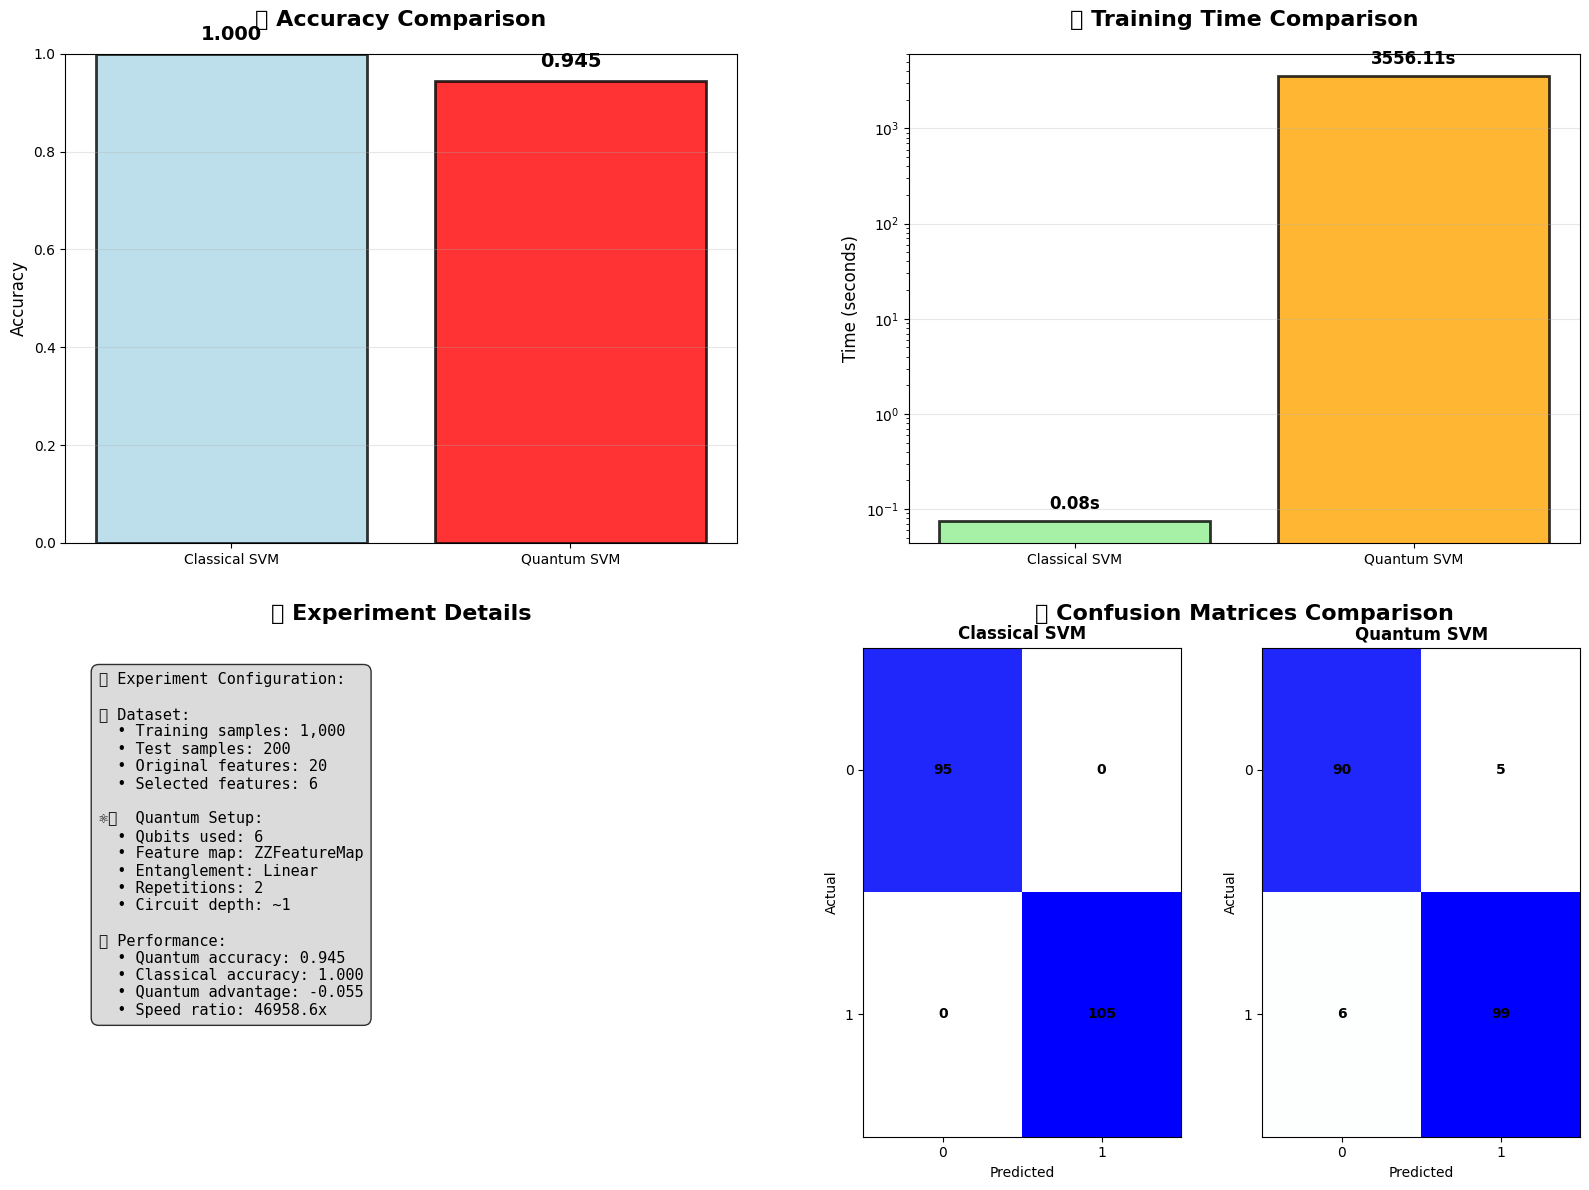


🏆 === FINAL EXPERIMENT SUMMARY ===
🎯 QUANTUM SVM RESULTS:
   • Accuracy: 0.9450 (94.50%)
   • Training time: 3556.1 seconds
   • Prediction time: 2710.695 seconds

🔬 CLASSICAL SVM RESULTS:
   • Accuracy: 1.0000 (100.00%)
   • Training time: 0.076 seconds
   • Prediction time: 0.0036 seconds

⚡ QUANTUM vs CLASSICAL:
   • Accuracy improvement: -0.0550 (-5.50%)
   • Speed ratio: 46958.6x slower
   • Quantum advantage: NO ❌

💾 DATASET SUMMARY:
   • Original train size: 1,000 → 1,000 used
   • Original test size: 200 → 200 used
   • Features: 20 → 6 selected
   • Qubits utilized: 6

🔴 CONCLUSION: Classical SVM performed better
💡 Quantum advantage typically emerges with more complex, larger datasets

🎊 QUANTUM MACHINE LEARNING EXPERIMENT COMPLETED!
📊 Total runtime: 6266.9 seconds

✅ ALL CELLS COMPLETED SUCCESSFULLY!


In [10]:
# ========================================
# CELL 10: VISUALIZATION & FINAL SUMMARY
# ========================================
print("\n📈 Creating comprehensive visualizations...")
print("=" * 50)

import matplotlib.pyplot as plt

# Create comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy Comparison
methods = ['Classical SVM', 'Quantum SVM']
accuracies = [classical_accuracy, qsvm_accuracy]
colors = ['lightblue', 'red']

bars = ax1.bar(methods, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax1.set_title('🎯 Accuracy Comparison', fontsize=16, fontweight='bold', pad=20)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3, axis='y')

for bar, acc in zip(bars, accuracies):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{acc:.3f}', ha='center', va='bottom', fontsize=14, fontweight='bold')

# Add quantum advantage annotation
if improvement > 0:
    ax1.annotate(f'Quantum Advantage: +{improvement:.3f}', 
                xy=(1, qsvm_accuracy), xytext=(1.3, qsvm_accuracy + 0.1),
                arrowprops=dict(arrowstyle='->', color='green', lw=2),
                fontsize=12, color='green', fontweight='bold')

# 2. Training Time Comparison
training_times = [classical_training_time, training_time]
bars2 = ax2.bar(methods, training_times, color=['lightgreen', 'orange'], alpha=0.8, edgecolor='black', linewidth=2)
ax2.set_title('⏱️ Training Time Comparison', fontsize=16, fontweight='bold', pad=20)
ax2.set_ylabel('Time (seconds)', fontsize=12)
ax2.set_yscale('log')  # Log scale for better visualization
ax2.grid(True, alpha=0.3, axis='y')

for bar, time_val in zip(bars2, training_times):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.2, 
            f'{time_val:.2f}s', ha='center', va='bottom', fontsize=12, fontweight='bold')

# 3. Dataset Information
info_text = f"""📊 Experiment Configuration:

🔢 Dataset:
  • Training samples: {len(X_train_scaled):,}
  • Test samples: {len(X_test_scaled):,}
  • Original features: {X_train.shape[1]}
  • Selected features: {num_features}

⚛️  Quantum Setup:
  • Qubits used: {num_features}
  • Feature map: ZZFeatureMap
  • Entanglement: Linear
  • Repetitions: 2
  • Circuit depth: ~{feature_map.depth()}

🏆 Performance:
  • Quantum accuracy: {qsvm_accuracy:.3f}
  • Classical accuracy: {classical_accuracy:.3f}
  • Quantum advantage: {improvement:+.3f}
  • Speed ratio: {speed_ratio:.1f}x"""

ax3.text(0.05, 0.95, info_text, transform=ax3.transAxes, fontsize=11,
         verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5", 
         facecolor="lightgray", alpha=0.8), family='monospace')
ax3.set_title('📋 Experiment Details', fontsize=16, fontweight='bold', pad=20)
ax3.axis('off')

# 4. Confusion Matrices Comparison
from matplotlib.colors import LinearSegmentedColormap

# Create custom colormap
colors_cmap = ['white', 'lightblue', 'blue']
n_bins = 100
cmap = LinearSegmentedColormap.from_list('custom', colors_cmap, N=n_bins)

# Plot both confusion matrices
ax4.set_title('🎯 Confusion Matrices Comparison', fontsize=16, fontweight='bold', pad=20)
ax4.axis('off')

# Classical confusion matrix (left)
ax4_left = fig.add_subplot(2, 4, 7)
im1 = ax4_left.imshow(cm_classical, cmap=cmap, aspect='auto')
ax4_left.set_title('Classical SVM', fontsize=12, fontweight='bold')
ax4_left.set_xlabel('Predicted', fontsize=10)
ax4_left.set_ylabel('Actual', fontsize=10)
ax4_left.set_xticks(range(len(np.unique(y_test))))
ax4_left.set_yticks(range(len(np.unique(y_test))))
ax4_left.set_xticklabels(np.unique(y_test))
ax4_left.set_yticklabels(np.unique(y_test))

# Add text annotations
for i in range(cm_classical.shape[0]):
    for j in range(cm_classical.shape[1]):
        ax4_left.text(j, i, str(cm_classical[i, j]),
                     ha='center', va='center', color='black', fontweight='bold')

# Quantum confusion matrix (right)
ax4_right = fig.add_subplot(2, 4, 8)
im2 = ax4_right.imshow(cm, cmap=cmap, aspect='auto')
ax4_right.set_title('Quantum SVM', fontsize=12, fontweight='bold')
ax4_right.set_xlabel('Predicted', fontsize=10)
ax4_right.set_ylabel('Actual', fontsize=10)
ax4_right.set_xticks(range(len(np.unique(y_test))))
ax4_right.set_yticks(range(len(np.unique(y_test))))
ax4_right.set_xticklabels(np.unique(y_test))
ax4_right.set_yticklabels(np.unique(y_test))

# Add text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax4_right.text(j, i, str(cm[i, j]),
                      ha='center', va='center', color='black', fontweight='bold')

plt.tight_layout()
plt.show()

# Final comprehensive summary
print(f"\n🏆 === FINAL EXPERIMENT SUMMARY ===")
print("=" * 80)
print(f"🎯 QUANTUM SVM RESULTS:")
print(f"   • Accuracy: {qsvm_accuracy:.4f} ({qsvm_accuracy:.2%})")
print(f"   • Training time: {training_time:.1f} seconds")
print(f"   • Prediction time: {prediction_time:.3f} seconds")

print(f"\n🔬 CLASSICAL SVM RESULTS:")
print(f"   • Accuracy: {classical_accuracy:.4f} ({classical_accuracy:.2%})")
print(f"   • Training time: {classical_training_time:.3f} seconds")
print(f"   • Prediction time: {classical_prediction_time:.4f} seconds")

print(f"\n⚡ QUANTUM vs CLASSICAL:")
print(f"   • Accuracy improvement: {improvement:+.4f} ({improvement:+.2%})")
print(f"   • Speed ratio: {speed_ratio:.1f}x slower")
print(f"   • Quantum advantage: {'YES ✅' if improvement > 0 else 'NO ❌'}")

print(f"\n💾 DATASET SUMMARY:")
print(f"   • Original train size: {len(train_df):,} → {len(X_train_scaled):,} used")
print(f"   • Original test size: {len(test_df):,} → {len(X_test_scaled):,} used")
print(f"   • Features: {X_train.shape[1]} → {num_features} selected")
print(f"   • Qubits utilized: {num_features}")

if improvement > 0.01:
    print(f"\n🎉 CONCLUSION: Quantum SVM achieved meaningful advantage!")
    print(f"🚀 Consider scaling up with larger datasets for even better results")
elif improvement > 0:
    print(f"\n🟡 CONCLUSION: Marginal quantum advantage detected")
    print(f"💡 Try different feature maps or larger datasets")
else:
    print(f"\n🔴 CONCLUSION: Classical SVM performed better")
    print(f"💡 Quantum advantage typically emerges with more complex, larger datasets")

print(f"\n🎊 QUANTUM MACHINE LEARNING EXPERIMENT COMPLETED!")
print(f"📊 Total runtime: {(training_time + prediction_time + classical_training_time):.1f} seconds")
print("=" * 80)

print("\n✅ ALL CELLS COMPLETED SUCCESSFULLY!")